## Combine GroundingDINO with SegmentAnythingModel
- Use [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) for zero-shot object detection (bboxes)
- Use Segment Anything Model ([SAM](https://github.com/facebookresearch/segment-anything)) for converting detections into segmentations

***
## Imports and Installs

In [36]:
import os
from glob import glob

import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
from torchvision import transforms as T
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.ops import nms

In [2]:
%pip install -qqq git+https://github.com/tkra90/magic.git

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tinymagic

***
### Install SAM & Load Weights

In [4]:
%pip install -qqq git+https://github.com/facebookresearch/segment-anything.git

Note: you may need to restart the kernel to use updated packages.


In [5]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/kaggle/input/segment-anything/pytorch/vit-b/1/model.pth"
model_type = "vit_b"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)

predictor = SamPredictor(sam)

***
### Install GroundingDINO & Download Weights 

In [6]:
%%capture

!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd GroundingDINO/
%pip install -qqq -e .

# download weights
%mkdir weights
%cd weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
%cd ..

In [7]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
from groundingdino.util import box_ops

dino_model = load_model("groundingdino/config/GroundingDINO_SwinT_OGC.py", "weights/groundingdino_swint_ogc.pth")
dino_model.to(device);

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


***
### Load dataset

In [310]:
FLOOD_DS_ROOT = '/kaggle/input/flood-area-segmentation'
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_files = sorted(glob(FLOOD_DS_ROOT+"/Image/*"))

image_source, image = load_image(image_files[6])

***
### Detect Bounding Boxes with GroundingDINO

In [253]:
%%time

# TEXT_PROMPT = "houses with white roof "
TEXT_PROMPT = "cars "

boxes, logits, phrases = predict(
    model=dino_model,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

CPU times: user 265 ms, sys: 1.97 ms, total: 267 ms
Wall time: 261 ms


In [311]:
len(phrases)

14

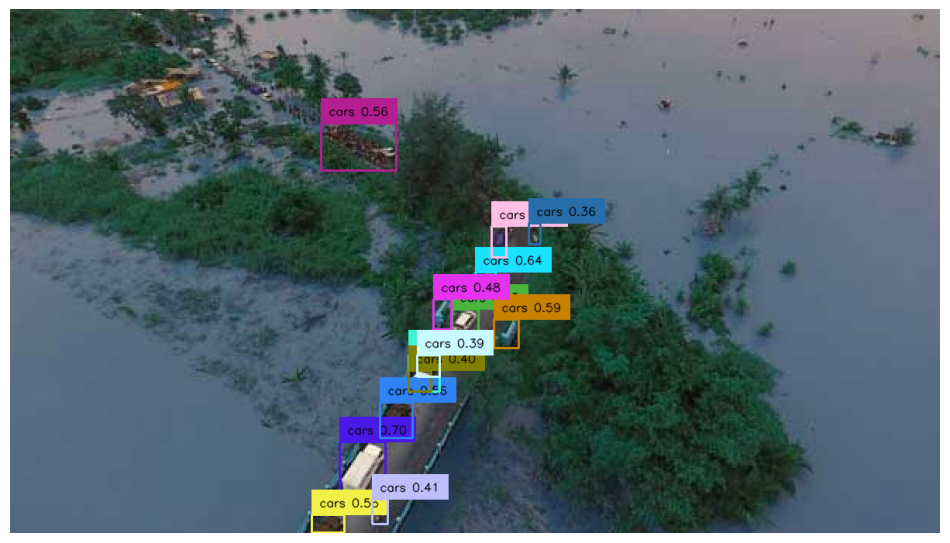

In [312]:
plt.figure(figsize=(12,9))
plt.axis('off')
plt.imshow(annotated_frame);

***
### Predict Masks with SAM

In [ ]:
H,W,_ = image_source.shape

In [ ]:
bbx = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W,H,W,H])

In [ ]:
# Apply NMS
threshold = 0.45
keep_indices = nms(bbx, scores=logits, iou_threshold=threshold)

# Filter the bounding boxes based on the indices returned by NMS
filtered_bboxes = bbx[keep_indices]

In [ ]:
transformed_boxes = predictor.transform.apply_boxes_torch(filtered_bboxes, image_source.shape[:2])

In [318]:
predictor.set_image(image_source)
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes= transformed_boxes.to(device), #transformed_boxes.numpy(),
    multimask_output=False,
)

In [320]:
masks.shape

torch.Size([14, 1, 676, 1200])

In [321]:
msk = masks.squeeze(1).cpu()
msk.shape

torch.Size([14, 676, 1200])

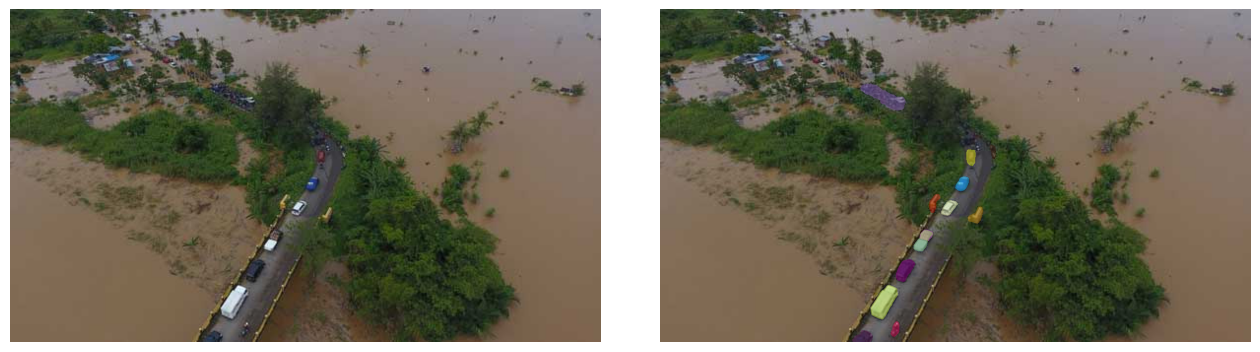

In [327]:
# Plot the original image and the mask
fig, axs = plt.subplots(1, 2, figsize=(16, 16))
plt.subplots_adjust(wspace=0.1,hspace=0.1)

axs[0].imshow(image_source)
axs[0].axis('off')
axs[1].imshow(image_source)
axs[1].axis('off')
ax = plt.gca()
ax.set_autoscale_on(False)

for m in msk:
#     import pdb; pdb.set_trace()
    img = np.ones((m.shape[0], m.shape[1], 3))
    color_mask = np.random.random((1, 3)).tolist()[0]
    for i in range(3):
        img[:,:,i] = color_mask[i]
    axs[1].imshow(np.dstack((img, m*0.5)))